# Classifying IMDB movie reviews using RNNs and a 1D CNN<a id="Top"></a>

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
Table of Content
<ul>
    <li>1. <a href="#Part_1">Data preprocessing</a></li>
    <li>2  <a href="#Part_2">Tokenizing the raw IMDB data</a></li>
    <li>3. <a href="#Part_3">Learning word embeddings with the Embedding layer</a></li>
    <li>4. <a href="#Part_4">Using precomputed word embeddings</a></li>
    <li>5. <a href="#Part_5">Text data processing using a 1D CNN</a></li>
    <li>6. <a href="#Part_6">Summary</a></li>
</ul>    
</font>
</div>

In this notebook, we'll work on classifying the IMDB dataset, a set of 50,000 reviews from the Internet Movie
Database. The data is split into 25,000 reviews for training and 25,000 reviews for testing. Each set consists
of 50% positive and 50% negative reviews. The IMDB dataset comes packaged with Keras. But here we will work from 
the IMDB raw text data all the way to word embeddings.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import csv, os
import pickle

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Define auxiliary functions

In [2]:
def set_figuresize():
    # Define overall figure size. Use the Golden ratio to compute width and height.
    height = 6.0
    width = height*0.5*(1.0+np.sqrt(5.0))

    plt.rcParams['figure.figsize'] = (width, height)
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams['mathtext.rm'] = 'serif'
    
    
# -------------------------------------------------------------------------------
def plot_history(history, ymin=0.9, ymax=1.0):
    '''
    Simple function that plots metrics in the Keras history class.
    '''
    acc = history.history['acc']
    loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc)+1)
    
    plt.figure(figsize=(8,10))
    plt.subplots_adjust(hspace=0.2)
    
    plt.subplot(211)
    plt.plot(epochs, acc,     'bo-', markersize=3, label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', markersize=3, label='Validation acc')
    plt.ylim(ymin, ymax)
    plt.xlim(0, len(acc)+1)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    
    plt.subplot(212)
    plt.plot(epochs, loss,     'bo-', markersize=3, label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', markersize=3, label='Validation loss')
    plt.xlim(0, len(acc)+1)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()
    
    plt.show()    
    

# -------------------------------------------------------------------------------
def load_RawIMDB(imdb_dir, dataset='train'):
    '''
    Load raw IMDB reviews from files and turn them into a pandas dataframe.
    
    Arguments :
       imdb_dir - Path to the raw IMDB review dataset 
        dataset - Could be 'train' or 'test'.    
    '''
    index = 0
    data_dir = os.path.join(imdb_dir, dataset)
    
    df_imdb = pd.DataFrame(columns=['label', 'review'])
    for label_type in ['pos/', 'neg/']:
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            index += 1
            if index%1000 == 0:
                print(' Processing batch #{0}'.format(index))
            frame = pd.read_table(dir_name+fname, header=None, quoting=csv.QUOTE_NONE)
            if label_type == 'pos/':
                label = 1
            else:
                label = 0
            df_imdb = df_imdb.append({'label':label, 'review':frame.iloc[0][0]}, ignore_index=True)
            
    return df_imdb      

# 1. Data preprocessing<a id="Part_1"></a>
<a href="#Top">Back to page top</a>

Load up the IMDB raw review data. The folder `aclImdb` consists of two subfolers `train` and `test` containing
training and test datasets respectively. In each of the folders, the reviews are further categorized into positive
and negative reviews. The reviews will be labeled accordingly.

Here we use pandas to import and combine individual reviews into a big dataframe. The trick here is to create
an empty dataframe with two columns `['label', 'review']`. Each of the reviews is imported to a placeholder
dataframe using `pd.read_table()`. Finally, we pack the review stored in the temporary dataframe along with
its label (i.e. name of the folder where the review resides) into a dictionary, and append the dictionary to 
the target dataframe.

In [3]:
imdb_file = './datasets/imdb_train.csv'
imdb_dir = './datasets/aclImdb/'

In [4]:
if os.path.isfile(imdb_file):
    df_imdb = pd.read_csv(imdb_file)
else:
    df_imdb = load_RawIMDB(imdb_dir, dataset='train')
    df_imdb.to_csv('./datasets/imdb_train.csv', index=False)        

Showing the first and last few rows of the dataframe:

In [5]:
df_imdb.head()

,label,review
0,1,Audiences today will probably watch a film lik...
1,1,"I saw this movie about a year ago, and found i..."
2,1,This movie is about human relationships. Charm...
3,1,"These are excerpts from a nine-page ""Memo to M..."
4,1,Wonderful romance comedy drama about an Italia...


In [6]:
df_imdb.tail()

,label,review
24995,0,"OK so there's nudity, but hey, there's free po..."
24996,0,I'm a fan of the series and have read all 7 bo...
24997,0,This has to be one of the worst movies I've ev...
24998,0,"No, I've never seen any of the ""Santa Slasher""..."
24999,0,"This is listed as a documentary, it's not, it'..."


# 2. Tokenizing the raw IMDB data<a id="Part_2"></a>
<a href="#Top">Back to page top</a>

Here we will utilize two classes packaged in Keras: `Tokenizer` and `pad_sequence`.
1. __`Tokenizer`__: The most critical argument is `num_words`. This argument determines the maximum number of 
   words to keep, based on word frequency. Only the most common `num_words` words will be kept. Tokenizer
   by default will filter out all punctuation (except the `'` character), tabs, and line breaks. One can 
   supply a custom filter through the argument `filter=filter_string`, where `filter_string` contains the
   symbols to be ignored by Tokenizer. The delimiter can be specified through `split = delimiter_string`. 
   By default ``split = ` ```.
   ```python
        Tokenizer(num_words=None, split=` `)```
2. __`pad_sequences`__: IMDB reviews have various number of words. To deal with inputs with variable lenghths,
   one can set the maximum number of word in the input. For reviews that have fewers words, it is necessary to
   pad them with zeroes. This is what the function does.

In [7]:
num_unique_tokens    = 20000    # consider top 20,000 most common words in the whole IMDB dataset

tokenizer = Tokenizer(num_words = num_unique_tokens)
tokenizer.fit_on_texts( np.asarray( df_imdb['review'] ) )
sequences = tokenizer.texts_to_sequences( np.asarray( df_imdb['review'] ) )
word_index = tokenizer.word_index
print(' Found {0} unique tokens'.format(len(word_index)))

 Found 88521 unique tokens


Let's compare the data's raw and tokenized versions. First the review, then it is followed by its tokenization.

In [8]:
idx = 40
print(df_imdb['review'][idx].split())
print('\n Review length in words: {}'.format(len(df_imdb['review'][idx].split())))

['The', 'movie', 'is', 'a', 'bit', '"thin"', 'after', 'reading', 'the', 'book,', 'but', "it's", 'still', 'one', 'of', 'the', 'greatest', 'movies', 'ever', 'made.', 'Sheryl', 'Lee', 'is', 'beautiful', 'and', 'Nick', 'Nolte', 'is', 'really', '"vonneguty".', 'He', 'makes', 'great', 'job', 'expressing', 'the', 'feelings', 'from', 'the', 'book', 'to', 'the', 'film.', 'Not', 'many', 'films', 'engage', 'the', 'feeling', 'of', 'the', 'book', 'as', 'well', 'as', 'Mother', 'Night', 'does.']

 Review length in words: 58


In [9]:
print(sequences[idx])
print('\n Sequence length: {}'.format(len(sequences[idx])))

[1, 17, 6, 3, 224, 1532, 100, 883, 1, 271, 18, 42, 128, 28, 4, 1, 830, 99, 123, 90, 15500, 845, 6, 304, 2, 1848, 6191, 6, 63, 27, 163, 84, 289, 9095, 1, 1421, 36, 1, 271, 5, 1, 19, 21, 108, 105, 4518, 1, 544, 4, 1, 271, 14, 70, 14, 449, 311, 124]

 Sequence length: 57


Next we take a look at the length (in words) distribution for positive and negative reviews.

In [10]:
pcount = []
ncount = []
for i in range(25000):
    if i < 12500:
        pcount.append(len(sequences[i]))
    else:
        ncount.append(len(sequences[i]))
print(' maximum number of words in positive reviews:', np.max(pcount))
print(' maximum number of words in negative reviews:', np.max(ncount))

 maximum number of words in positive reviews: 2340
 maximum number of words in negative reviews: 1493


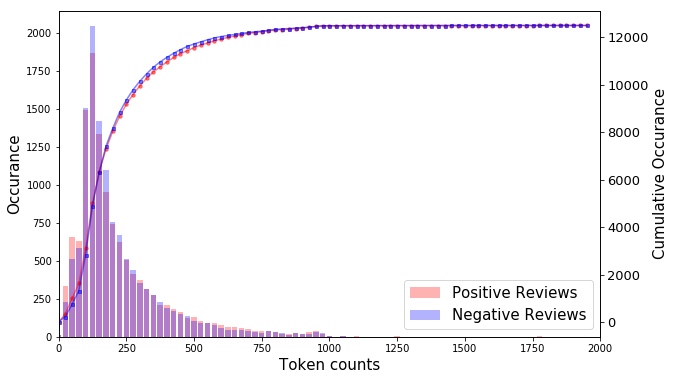

In [11]:
bins = range(0, 2000, 25)

hp, bp = np.histogram(pcount, bins=bins)
hn, bn = np.histogram(ncount, bins=bins)  

set_figuresize()
fig, ax1 = plt.subplots()
ax1.bar(bp[:-1], hp, width=20, fc='r', alpha=0.3, label='Positive Reviews')
ax1.bar(bn[:-1], hn, width=20, fc='b', alpha=0.3, label='Negative Reviews')
ax1.set_xlabel('Token counts', fontsize=15)
ax1.set_ylabel('Occurance', fontsize=15)
ax1.legend(fontsize=15, loc='lower right')

ax2 = ax1.twinx()
ax2.plot(bp[:-1], np.cumsum(hp), 'ro-', ms=3.4, alpha=0.5)
ax2.plot(bn[:-1], np.cumsum(hn), 'bs-', ms=3.0, alpha=0.5)
ax2.set_ylabel('Cumulative Occurance', fontsize=15)

plt.xlim([0, 2000])

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

The distribution for positive review and that of negative review are very similar. Also, the majority of 
the reviews are of length less than 400 words. Since our network can only take inputs with fixed length,
we will have to truncate the reviews. The similar distributions indicate that the truncation will do a
similar level of impact, at least in the number of words, to both type of reviews.

Cutting the reviews is done through Keras
`pad_sequence` function with the following defaults
```python
    pad_sequences(sequences, maxlen=None, padding='pre', truncating='pre', value=0.0)```
`pad_Sequence` will take a 2D tensor of shape `(num_of_samples, None)`  and convert it into a 2D tensor with shape
`(num_of_samples, maxlen)`. Sequences shorter than `maxlen` are padded with `value`. Sequences longer 
than `maxlen` are truncated. The location of padding and truncation is determined by `padding` and `truncating`:
- `padding` = `'pre'` or `'post'`: pad either before or after each sequence.
- `truncating` = `'pre'` or `'post'`: remove values from sequences larger than `maxlen`, either at the beginning 
  or at the end of the sequences.

In [12]:
max_words_per_review = 200     # consider the firtst 200 words in each review

data = pad_sequences(sequences, maxlen = max_words_per_review)
labels = np.asanyarray(df_imdb['label'])
print(' Shape of data tensor:', data.shape)
print(' Shape of label tensor:', labels.shape)

 Shape of data tensor: (25000, 200)
 Shape of label tensor: (25000,)


Now that the review data has been tokenized and labels have been prepared, the next step is to generate training
and validation sets. We'll use Scikit-Learn's `train_test_split()` function.

In [13]:
train_size           = 9000     # size of the training sample
validation_size      = 3500     # size of the validation sample

x_train, x_val, y_train, y_val = train_test_split(data, 
                                                  labels, 
                                                  test_size = validation_size, 
                                                  train_size = train_size,
                                                  random_state = 71)
print('   training tensor shape:',x_train.shape)
print(' validation tensor shape:',x_val.shape)

   training tensor shape: (9000, 200)
 validation tensor shape: (3500, 200)


Preprocess the test dataset.

In [14]:
# ------------------------------------------
# Load the test set file
# ------------------------------------------
imdb_file = './datasets/imdb_test.csv'

if os.path.isfile(imdb_file):
    df_imdb = pd.read_csv(imdb_file)
else:
    df_imdb = load_RawIMDB(imdb_dir, dataset='test')
    df_imdb.to_csv('./datasets/imdb_test.csv', index=False)        

# ------------------------------------------
# Tokenization    
# ------------------------------------------
num_unique_tokens    = 20000    # consider top 10,000 most common words in the whole IMDB dataset

tokenizer = Tokenizer(num_words = num_unique_tokens)
tokenizer.fit_on_texts( np.asarray( df_imdb['review'] ) )
sequences = tokenizer.texts_to_sequences( np.asarray( df_imdb['review'] ) )
word_index = tokenizer.word_index
print(' Found {0} unique tokens'.format(len(word_index)))    

# ------------------------------------------
# Padding and cutting the reviews
# ------------------------------------------
max_words_per_review = 200     # consider the firtst 200 words in each review

x_test = pad_sequences(sequences, maxlen = max_words_per_review)
y_test = np.asanyarray(df_imdb['label'])
print(' Shape of data tensor:', data.shape)
print(' Shape of label tensor:', labels.shape)

 Found 87350 unique tokens
 Shape of data tensor: (25000, 200)
 Shape of label tensor: (25000,)


# 3. Learning word embeddings with the `Embedding` layer<a id="Part_3"></a>
<a href="#Top">Back to page top</a>

The first RNN demonstration is learning word embeddings with the Keras `Embedding` layer. The `Embedding` layer
is co-trained with an LSTM layer whose output dimension is set to be 100. This is a hyperparameter that can 
be tuned. Because this is a binary classification problem, the `Dense` layer's activation is a sigmoid function.
The loss function is using `binary_crossentropy`. The network's initial weights are also stored for the next
section.

In [15]:
embedding_dim = 50

model = Sequential()
model.add( Embedding(num_unique_tokens, 
                     embedding_dim, 
                     input_length = max_words_per_review) )
model.add( LSTM(100) )
model.add( Dense(1, activation = 'sigmoid') )
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics=['acc'])
model.summary()

model.save_weights('imdb_RNN_initial_weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 50)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,060,501
Trainable params: 1,060,501
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size = 64,
                    validation_data = (x_val, y_val))

model.save('imdb_RNN_train_embeddings.h5')
with open('imdb_RNN_train_embeddings_history.pickle', 'wb') as history_file:
    pickle.dump(history, history_file)

Train on 9000 samples, validate on 3500 samples
Epoch 1/10
9000/9000 [==============================] - 27s 3ms/step - loss: 0.5462 - acc: 0.7291 - val_loss: 0.5034 - val_acc: 0.7491
Epoch 2/10
9000/9000 [==============================] - 26s 3ms/step - loss: 0.3100 - acc: 0.8796 - val_loss: 0.3694 - val_acc: 0.8591
Epoch 3/10
9000/9000 [==============================] - 26s 3ms/step - loss: 0.2274 - acc: 0.9154 - val_loss: 0.3563 - val_acc: 0.8411
Epoch 4/10
9000/9000 [==============================] - 26s 3ms/step - loss: 0.1665 - acc: 0.9432 - val_loss: 0.4537 - val_acc: 0.7906
Epoch 5/10
9000/9000 [==============================] - 26s 3ms/step - loss: 0.1360 - acc: 0.9541 - val_loss: 0.4342 - val_acc: 0.8546
Epoch 6/10
9000/9000 [==============================] - 26s 3ms/step - loss: 0.0949 - acc: 0.9694 - val_loss: 0.4513 - val_acc: 0.8383
Epoch 7/10
9000/9000 [==============================] - 26s 3ms/step - loss: 0.0761 - acc: 0.9748 - val_loss: 0.5109 - val_acc: 0.8174
Epoch 8

We are ready to examine the trainig history.

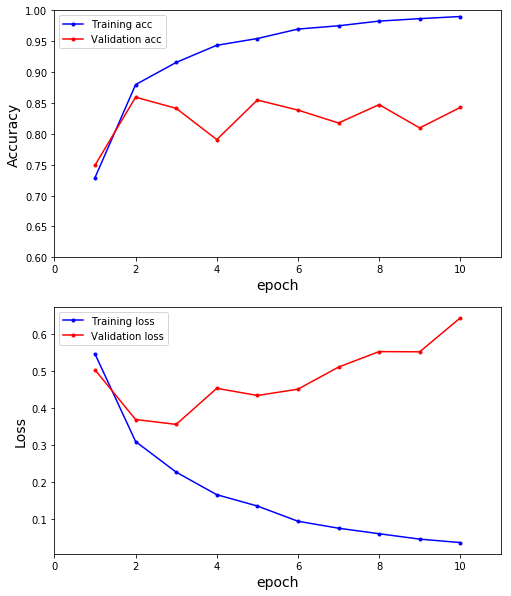

In [17]:
h = pickle.load( open('imdb_RNN_train_embeddings_history.pickle', 'rb'))
plot_history(h, ymin=0.6)

The validation accuracy tops at around 85%. But the network quickly overfits. Let's evaluate the network on the
test set.

In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('     Test loss:', test_loss)
print(' Test accuracy:', test_acc)

25000/25000 [==============================] - 38s 2ms/step
     Test loss: 2.2156855512237548
 Test accuracy: 0.51748


# 4. Using precomputed word embeddings<a id="Part_4"></a>
<a href="#Top">Back to page top</a>

In this section, we choose to work with the GloVe word embeddings. Specifically, we will use the GloVe embedding
from 2014 English Wikipedia. The embedding's file name is glove.6B.zip, which can be downloaded from GloVe's
<a href='https://nlp.stanford.edu/projects/glove/'>website</a>. After the file is unzipped, we'll load the file
glove.6B.50d.txt. As the file name suggests, the dimension of the embedding space is 50. The file has 400K tokens. The embedding can be loaded into a dataframe using pandas `read_table()` function. We set `header=None` because the
embedding file has no header. `quoting=csv.QUOTE_NONE` informs the file reader to perform no special processing of
quote characters. `index_col=0` sets the first column of the file, which contains the tokens, as the index.

In [19]:
glove_path = './datasets/glove.6B.50d.txt'
df_glove = pd.read_table(glove_path, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
df_glove.head(10)

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
the,0.418000,0.249680,-0.41242,0.121700,0.345270,-0.044457,-0.49688,-0.178620,-0.000660,-0.656600,...,-0.298710,-0.157490,-0.347580,-0.045637,-0.442510,0.187850,0.002785,-0.184110,-0.115140,-0.785810
",",0.013441,0.236820,-0.16899,0.409510,0.638120,0.477090,-0.42852,-0.556410,-0.364000,-0.239380,...,-0.080262,0.630030,0.321110,-0.467650,0.227860,0.360340,-0.378180,-0.566570,0.044691,0.303920
.,0.151640,0.301770,-0.16763,0.176840,0.317190,0.339730,-0.43478,-0.310860,-0.449990,-0.294860,...,-0.000064,0.068987,0.087939,-0.102850,-0.139310,0.223140,-0.080803,-0.356520,0.016413,0.102160
of,0.708530,0.570880,-0.47160,0.180480,0.544490,0.726030,0.18157,-0.523930,0.103810,-0.175660,...,-0.347270,0.284830,0.075693,-0.062178,-0.389880,0.229020,-0.216170,-0.225620,-0.093918,-0.803750
to,0.680470,-0.039263,0.30186,-0.177920,0.429620,0.032246,-0.41376,0.132280,-0.298470,-0.085253,...,-0.094375,0.018324,0.210480,-0.030880,-0.197220,0.082279,-0.094340,-0.073297,-0.064699,-0.260440
and,0.268180,0.143460,-0.27877,0.016257,0.113840,0.699230,-0.51332,-0.473680,-0.330750,-0.138340,...,-0.069043,0.368850,0.251680,-0.245170,0.253810,0.136700,-0.311780,-0.632100,-0.250280,-0.380970
in,0.330420,0.249950,-0.60874,0.109230,0.036372,0.151000,-0.55083,-0.074239,-0.092307,-0.328210,...,-0.486090,-0.008027,0.031184,-0.365760,-0.426990,0.421640,-0.116660,-0.507030,-0.027273,-0.532850
a,0.217050,0.465150,-0.46757,0.100820,1.013500,0.748450,-0.53104,-0.262560,0.168120,0.131820,...,0.138130,0.369730,-0.642890,0.024142,-0.039315,-0.260370,0.120170,-0.043782,0.410130,0.179600
"""",0.257690,0.456290,-0.76974,-0.376790,0.592720,-0.063527,0.20545,-0.573850,-0.290090,-0.136620,...,0.030498,-0.395430,-0.385150,-1.000200,0.087599,-0.310090,-0.346770,-0.314380,0.750040,0.970650


Next we build an embeddding matrix that maps review tokens to GloVe word vectors. The embedding matrix is
essentially just a look-up table: given a token, the matrix gives its embedding vector.

In [20]:
glove_word_index = list(df_glove.index)

embedding_matrix = np.zeros((num_unique_tokens, embedding_dim))
for word, i in word_index.items():
    if i < num_unique_tokens:
        if i%1000 == 0:
            print(' Processing word #{0} in the token list'.format(i))
        if word in glove_word_index:
            embedding_matrix[i] = df_glove.loc[word].astype('float32')

 Processing word #1000 in the token list
 Processing word #2000 in the token list
 Processing word #3000 in the token list
 Processing word #4000 in the token list
 Processing word #5000 in the token list
 Processing word #6000 in the token list
 Processing word #7000 in the token list
 Processing word #8000 in the token list
 Processing word #9000 in the token list
 Processing word #10000 in the token list
 Processing word #11000 in the token list
 Processing word #12000 in the token list
 Processing word #13000 in the token list
 Processing word #14000 in the token list
 Processing word #15000 in the token list
 Processing word #16000 in the token list
 Processing word #17000 in the token list
 Processing word #18000 in the token list
 Processing word #19000 in the token list


We reuse the model defined previously. In order to do so, the network's initial weights will be loaded.

In [21]:
model.load_weights('imdb_RNN_initial_weights.h5')

Load the embedding matrix into the layer. Moreover, the layer needs to be frozen during training because we are
using pretrained embeddings. If not, the randomly initialized layer weights will trigger large gradient updates
which will erase the already-learned features.

In [22]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 50)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,060,501
Trainable params: 60,501
Non-trainable params: 1,000,000
_________________________________________________________________


The model summary confirms that the embedding weights are locked. Only the LSTM weights are trainable.
Let's train the network!

In [23]:
history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size = 64,
                    validation_data = (x_val, y_val))

model.save('imdb_RNN_GloVe_embeddings.h5')
with open('imdb_RNN_GloVe_embeddings_history.pickle', 'wb') as history_file:
    pickle.dump(history, history_file)

Train on 9000 samples, validate on 3500 samples
Epoch 1/10
9000/9000 [==============================] - 25s 3ms/step - loss: 0.6890 - acc: 0.5366 - val_loss: 0.6879 - val_acc: 0.5457
Epoch 2/10
9000/9000 [==============================] - 25s 3ms/step - loss: 0.6737 - acc: 0.5749 - val_loss: 0.6758 - val_acc: 0.5649
Epoch 3/10
9000/9000 [==============================] - 25s 3ms/step - loss: 0.6608 - acc: 0.5930 - val_loss: 0.6805 - val_acc: 0.5694
Epoch 4/10
9000/9000 [==============================] - 25s 3ms/step - loss: 0.6505 - acc: 0.6068 - val_loss: 0.6588 - val_acc: 0.5877
Epoch 5/10
9000/9000 [==============================] - 25s 3ms/step - loss: 0.6375 - acc: 0.6280 - val_loss: 0.6582 - val_acc: 0.5914
Epoch 6/10
9000/9000 [==============================] - 25s 3ms/step - loss: 0.6215 - acc: 0.6444 - val_loss: 0.6790 - val_acc: 0.6051
Epoch 7/10
9000/9000 [==============================] - 25s 3ms/step - loss: 0.6130 - acc: 0.6486 - val_loss: 0.6546 - val_acc: 0.6014
Epoch 8

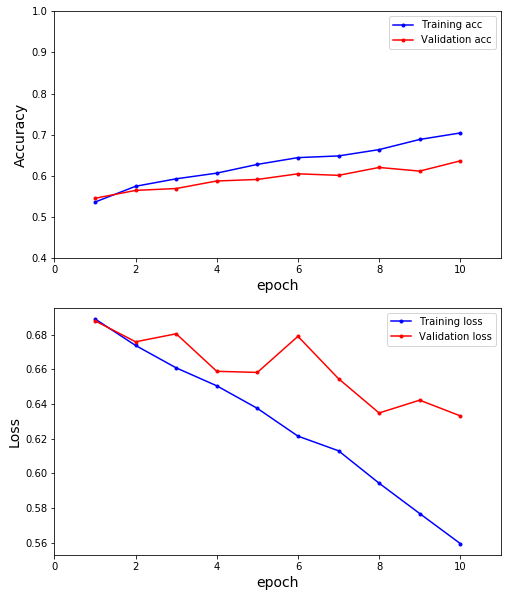

In [24]:
h = pickle.load( open('imdb_RNN_GloVe_embeddings_history.pickle', 'rb'))
plot_history(h, ymin=0.4)

Your milage may vary. But here it seems that using precomputed embeddings reduces overfitting a bit, relatively
speaking. However, the best accuracy is below 60%, which is significantly lower than the previous model's 
performance.

In [25]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('     Test loss:', test_loss)
print(' Test accuracy:', test_acc)

25000/25000 [==============================] - 39s 2ms/step
     Test loss: 0.7497919849395752
 Test accuracy: 0.54976


# 5. Text data processing with 1D CNN<a id="Part_5"></a>
<a href="#Top">Back to page top</a>

In the last part of the notebook, we'll use 1D CNN to classify the reviews. The convolutional layers we discussed
earluer extract two-dimensional patches from images and apply the same transformation to every patch. In the same
way, 1D convolutional layers extract 1D patches (subsequences) from sequences, as depicted below:

<img src='./images/fig_RNN-1dCNN.png' width=500>

In the 1D CNN setup, the filter window size is along the timestep direction. The dataset's input features are viewd
as convolutional layer's input channels.

Why using 1D CNN on text data? The idea is that the 1D convolutioanl layers can recognize local patterns in
sequence. Since the same input transformation is performed on every patch, a pattern learned at a certain position
in a sentence can later be recognized at different positions, making the 1D CNN layers translational invariant.
Following this line of thinking, a character-level 1D CNN is also a possible setup and is able to learn about
word morphology.

In Keras, a 1D CNN implements the `Conv1D` layer. Its interface is very similar to that of the `Conv2D` layer.
The `Conv1D` layer take as input 3D tensors of shape `(batch_size, timestep, features)` and return similar
shaped 3D tensors. The network's structure looks just like the 2D CNNs we have studied. The model consists
of a stack of `Conv1D` and `MaxPooling1D` layers, ending in either a global pooling or a `Flatten()` layer,
which turns 3D tensors into 2D tensors, allowing one to add `Dense` layers to the model for classification
or regression. Also, because of the 1D feature, here we can afford a much wider filter window size. Let's build
and train the network.

In [26]:
model_1dCNN = Sequential()
model_1dCNN.add( Embedding(num_unique_tokens, 
                           embedding_dim, 
                           input_length = max_words_per_review) )
model_1dCNN.add( Conv1D(50, 9, padding = 'same', activation = 'relu') )
model_1dCNN.add( MaxPooling1D(2) )
model_1dCNN.add( Conv1D(64, 9, padding = 'same', activation = 'relu') )
model_1dCNN.add( MaxPooling1D(2) )
model_1dCNN.add( Conv1D(64, 7, padding = 'same', activation = 'relu') )
model_1dCNN.add( MaxPooling1D(2) )
model_1dCNN.add( Conv1D(128, 7, padding = 'same', activation = 'relu') )
model_1dCNN.add( MaxPooling1D(2) )
model_1dCNN.add( Conv1D(128, 5, padding = 'same', activation = 'relu') )
model_1dCNN.add( GlobalMaxPooling1D() )
model_1dCNN.add( Dropout(0.5) )
model_1dCNN.add( Dense(64, activation = 'relu') )
model_1dCNN.add( Dropout(0.5) )
model_1dCNN.add( Dense(1, activation = 'sigmoid') )

model_1dCNN.summary()
model_1dCNN.compile(optimizer = RMSprop(lr=8.0e-5),
                    loss = 'binary_crossentropy',
                    metrics = ['acc'])
model_1dCNN.save_weights('imdb_1dCNN_initial_weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 50)           1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 50)           22550     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 64)           28864     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 64)            28736     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 25, 64)            0         
__________

In [27]:
history = model_1dCNN.fit(x_train, y_train,
                          epochs = 20,
                          batch_size = 128,
                          validation_data = (x_val, y_val))

model_1dCNN.save('imdb_1dCNN.h5')
with open('imdb_1dCNN_history.pickle', 'wb') as history_file:
    pickle.dump(history, history_file)

Train on 9000 samples, validate on 3500 samples
Epoch 1/20
9000/9000 [==============================] - 3s 367us/step - loss: 0.6934 - acc: 0.4983 - val_loss: 0.6931 - val_acc: 0.5034
Epoch 2/20
9000/9000 [==============================] - 1s 136us/step - loss: 0.6930 - acc: 0.5061 - val_loss: 0.6932 - val_acc: 0.5034
Epoch 3/20
9000/9000 [==============================] - 1s 142us/step - loss: 0.6930 - acc: 0.5060 - val_loss: 0.6932 - val_acc: 0.5034
Epoch 4/20
9000/9000 [==============================] - 1s 146us/step - loss: 0.6924 - acc: 0.5141 - val_loss: 0.6926 - val_acc: 0.5034
Epoch 5/20
9000/9000 [==============================] - 1s 140us/step - loss: 0.6911 - acc: 0.5307 - val_loss: 0.6903 - val_acc: 0.5417
Epoch 6/20
9000/9000 [==============================] - 1s 149us/step - loss: 0.6855 - acc: 0.5759 - val_loss: 0.6762 - val_acc: 0.6031
Epoch 7/20
9000/9000 [==============================] - 1s 149us/step - loss: 0.6382 - acc: 0.6899 - val_loss: 0.5949 - val_acc: 0.7060


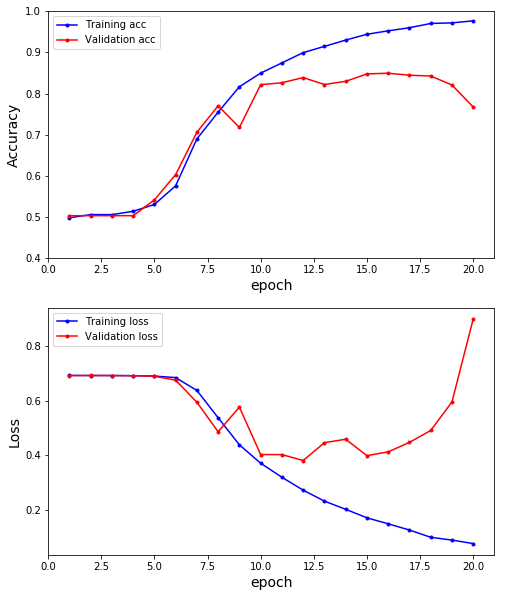

In [28]:
plot_history(history, ymin=0.4)

First of all, despite the fact that the 1D CNN has more weight parameters than the RNN networks, the training
is significantly faster. The best accuracy is ~83% before the network overfits. This result demonstrates that
1D CNN can offer a much cheaper alternative computationally to an RNN on the word-level sentiment classification.

In [29]:
test_loss, test_acc = model_1dCNN.evaluate(x_test, y_test)
print('     Test loss:', test_loss)
print(' Test accuracy:', test_acc)

25000/25000 [==============================] - 2s 76us/step
     Test loss: 2.1891235503330826
 Test accuracy: 0.52776


# 6. Summary<a id="Part_6"></a>
<a href="#Top">Back to page top</a>

To summarize, we have used recurrent and 1D convolutional neural networks to classify the IMDB movie reviews.
While the best training accuracy achineved so far is 83% ~ 85%, all three models suffer from different level
of overfitting. Our examples indicate that using precomputed word embeddings can alleviate overfitting.
However, we have made no attempt on tuning hyperparameters. Particularly, the number of words sampled from
the reviews may very well affect the networks ability to generalize. The large variance in the models' 
validation accuracy probably indicates this is indeed the case. I think this partially exains why the test
accuracy is only a bit better than 50% common sense baseline. Another reason is that analyzing the global, 
long-term structure of the reviews (what LSTM and 1D CNN are good at) isn’t helpful for a sentiment-analysis 
problem.